## Analysis part 2

In [35]:
from config import CONFIG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import series_to_supervised
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_json("eth-donation-requests.json")

In [3]:
df['tagged_begging'] = pd.to_datetime(df['tagged_begging'])

In [4]:
df = df.set_index(pd.DatetimeIndex(df['tagged_begging']))

In [5]:
df = df.groupby(pd.Grouper(key='tagged_begging', freq='15Min', base=0, label='right'))

In [6]:
df = df.describe()

In [7]:
df_count = df.unstack()['tagged_begging']['count']

In [8]:
values = df_count.values
#df_count.head()
type(values)

numpy.ndarray

In [9]:
values.shape

(9788,)

In [ ]:
#ax = df_count.plot()
#plt.show()

In [10]:
# parameters to prepare the dataset for learning # param 
n_lag = 96
n_out = 4
n_features = 1
n_lag,n_features,n_out

(96, 1, 4)

In [11]:
values.shape

(9788,)

In [12]:
values = values.reshape(values.shape[0], 1)
#values = values.reshape(-1, 1)

In [13]:
values.shape

(9788, 1)

In [14]:
# scale dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [41]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_lag, n_out)
reframed.head()

,var1(t-96),var1(t-95),var1(t-94),var1(t-93),var1(t-92),var1(t-91),var1(t-90),var1(t-89),var1(t-88),var1(t-87),...,var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
96,0.027397,0.082192,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,...,0.041096,0.054795,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082
97,0.082192,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,...,0.054795,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192
98,0.123288,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,...,0.109589,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986
99,0.095890,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,0.219178,...,0.068493,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986,0.150685
100,0.013699,0.054795,0.000000,0.054795,0.123288,0.109589,0.013699,0.041096,0.219178,0.178082,...,0.068493,0.082192,0.095890,0.123288,0.178082,0.178082,0.082192,0.136986,0.150685,0.191781


In [16]:
reframed_values = reframed.values
# split into train and test sets
training_size = int(0.8* reframed_values.shape[0])
train = reframed_values[:training_size, :]
test = reframed_values[training_size:, :]

In [17]:
# split into input and outputs
n_obs = n_lag * n_features

# We're only concerned with the estimating the close value,
# Close should be first in the list of column in the config file

n_outputs = n_out * n_features
train_x, train_y = train[:, :n_obs], train[:, -n_out:]
test_x, test_y = test[:, :n_obs], test[:, -n_out:]

# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], n_lag, n_features))
test_x = test_x.reshape((test_x.shape[0], n_lag, n_features))

# reshape output to be 3D [samples, timesteps, features]
train_y = train_y.reshape(-1, n_out, 1)
test_y = test_y.reshape(-1, n_out, 1)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

((7751, 96, 1), (7751, 4, 1), (1938, 96, 1), (1938, 4, 1))


In [29]:
model_name="model.json"
model_weights_name="weights.h5"

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM, CuDNNLSTM, GRU,CuDNNGRU
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
from keras.layers import Dropout, Flatten
from keras.layers import Activation, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint

units= CONFIG['lstm_hidden_size']
dropout = .1

# design network
model = Sequential()
model.add(Bidirectional(LSTM(units), input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(dropout))

model.add(RepeatVector(n_out))

model.add(LSTM(units/2, return_sequences=True))
model.add(Dropout(dropout))

# We're only concerned with the estimating the close value,
# otherwise use n_outputs instead of 1
# Dense(n_outputs, ...
model.add(TimeDistributed(Dense(1, activation='relu')))

model.compile(loss='mse', optimizer='adam')

# store model
# serialize model to JSON
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100)               20800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 25)             12600     
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 25)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 1)              26        
Total params: 33,426
Trainable params: 33,426
Non-trainable params: 0
_________________________________________________________________


In [31]:
epochs=100
batch_size=512

In [32]:
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(test_x, test_y), verbose=1, shuffle=False,
                    callbacks=[ModelCheckpoint(model_weights_name, monitor='val_loss', verbose=1,save_best_only='true',
                                              save_weights_only=True)])

Train on 7751 samples, validate on 1938 samples
Epoch 1/100
7751/7751 [==============================] - 13s 2ms/step - loss: 0.0116 - val_loss: 0.0129

Epoch 00001: val_loss improved from inf to 0.01292, saving model to weights.h5
Epoch 2/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0087 - val_loss: 0.0110

Epoch 00002: val_loss improved from 0.01292 to 0.01097, saving model to weights.h5
Epoch 3/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0075 - val_loss: 0.0096

Epoch 00003: val_loss improved from 0.01097 to 0.00957, saving model to weights.h5
Epoch 4/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0064 - val_loss: 0.0089

Epoch 00004: val_loss improved from 0.00957 to 0.00887, saving model to weights.h5
Epoch 5/100
7751/7751 [==============================] - 10s 1ms/step - loss: 0.0058 - val_loss: 0.0081

Epoch 00005: val_loss improved from 0.00887 to 0.00807, saving model to weights.h5
Epoch 6/100
7751/7


Epoch 00045: val_loss improved from 0.00555 to 0.00554, saving model to weights.h5
Epoch 46/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0040 - val_loss: 0.0057

Epoch 00046: val_loss did not improve from 0.00554
Epoch 47/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0039 - val_loss: 0.0056

Epoch 00047: val_loss did not improve from 0.00554
Epoch 48/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0040 - val_loss: 0.0057

Epoch 00048: val_loss did not improve from 0.00554
Epoch 49/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0039 - val_loss: 0.0056

Epoch 00049: val_loss did not improve from 0.00554
Epoch 50/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0040 - val_loss: 0.0057

Epoch 00050: val_loss did not improve from 0.00554
Epoch 51/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0039 - val_loss: 0.0055

Epoch 00051: val_loss improved 

7751/7751 [==============================] - 9s 1ms/step - loss: 0.0036 - val_loss: 0.0056

Epoch 00098: val_loss did not improve from 0.00551
Epoch 99/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0036 - val_loss: 0.0056

Epoch 00099: val_loss did not improve from 0.00551
Epoch 100/100
7751/7751 [==============================] - 9s 1ms/step - loss: 0.0035 - val_loss: 0.0057

Epoch 00100: val_loss did not improve from 0.00551


In [33]:
# Load the best weights
model.load_weights(model_weights_name)
model.compile(loss='mse', optimizer='adam')
model.evaluate(test_x, test_y)

1938/1938 [==============================] - 2s 872us/step


0.005513833901317266

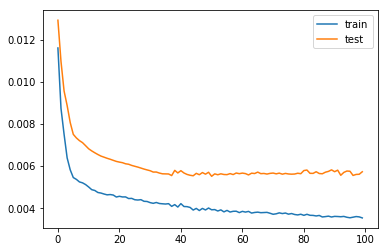

In [36]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
# Test the prediction of test data
y = model.predict(test_x)

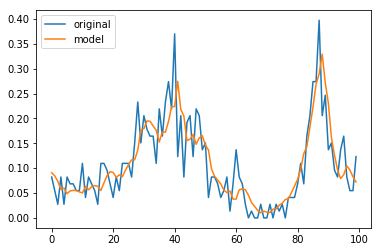

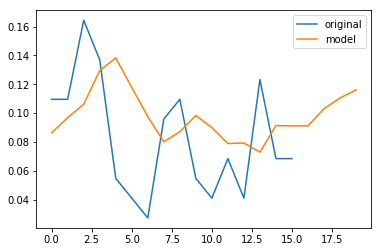

In [38]:
a = test_y[:,0]
b = y[:,0]
c = np.append(b, y[-1], axis=0)

# Show how the model fits the test data
pyplot.plot(a[:100], label='original')
pyplot.plot(b[:100], label='model')
pyplot.legend()
pyplot.show()

# Show how the model predicts data
pos = int(a.shape[0]-n_out*4)
pyplot.plot(a[pos:], label='original')
pyplot.plot(c[pos:], label='model')
pyplot.legend()
pyplot.show()
